# Codon position (CP) mutation bar charts

This notebook says "histogram" a lot, but ... really these are bar charts. The Marcus who wrote this notebook a few months ago was such an innocent young lad.

In [10]:
%run "Header.ipynb"
%run "GeneUtils.ipynb"

In [11]:
import pileup
seq2pos2pileup = pileup.load()

In [12]:
from parse_sco import parse_sco

In [30]:
def histogram_of_123(vals, title, axes, xlabel="Codon Position", ylabel="Number of Mutated Positions",
                     format_yaxis="thousands", max_val=None, show_ylabel=True, show_xlabel=True):
    if len(vals) == 3:
        one, two, three = vals
        x = [1, 2, 3]
        labels = ["1", "2", "3"]
    elif len(vals) == 4:
        one, two, three, four = vals
        x = [1, 2, 3, 4]
        labels = ["1", "2", "3", "Non-Coding"]
    else:
        raise ValueError("Not 3 or 4 vals passed?")
    axes.bar(
        x=x,
        height=vals,
        color=[cp2color[i + 1] for i in range(len(vals))],
        edgecolor=BORDERCOLOR,
        tick_label=labels
    )
    
    if max_val is None:
        ypad = 0.04 * max(vals)
    else:
        ypad = 0.04 * max_val
    # to make interpreting the plots easier, show text for each bar
    # just above it: https://stackoverflow.com/a/30229062
    # and https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh/30229062#comment86813015_30229062
    for xi, yval in enumerate(vals, 1):
        # Used to make decision about normalized vs unnormalized values
        if format_yaxis == "percentages":
            text = f"{(yval * 100):.2f}%"
        else:
            text = f"{yval:,}"
        axes.text(xi, yval + ypad, text, ha="center")
        
    print(title, vals)
    if three > one and one > two:
        axes.set_title(title)
    else:
        axes.set_title(title, color="#cc3322", fontweight="semibold")
            
    if show_xlabel:
        axes.set_xlabel(xlabel)
    if show_ylabel:
        axes.set_ylabel(ylabel)
        
    if format_yaxis == "thousands":
        use_thousands_sep(axes.get_yaxis())
    elif format_yaxis == "percentages":
        # Make the y-axis show percentages: based on
        # https://old.reddit.com/r/learnpython/comments/7adhnk/matplotlib_setting_y_axis_labels_to_percent_yaxis/dp93fwq/
        # (This is duplicated within this notebook... TODO, make this a function like use_thousands_sep()?)
        axes.get_yaxis().set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=2))
    else:
        raise ValueError("Unrecognized format_yaxis value: {}".format(format_yaxis))
        
    # Shoddy way to add padding -- see https://stackoverflow.com/a/42804403
    max_yval_pad = 1.2
    if max_val is None:
        max_val = max(vals)    
    axes.set_ylim(0, max_val * max_yval_pad)

def histogram_maker(
    p,
    title,
    axes,
    ylabel="Number of Mutated Positions",
    normalize=False,
    add_noncoding_col=True,
    make_yaxes_comparable=False,
    show_xlabel=True,
    show_ylabel=True,
    already_done_calls=None,
):
    """
    Produces histograms of pileup data for the 1st, 2nd, and 3rd positions of predicted genes.

    Parameters
    ----------
    p: float
        In the range [0, 1].
        
    title: str
        Will be included after the seq name in every histogram. For example, if this is "blah blah",
        then each histogram will say "CAMP: blah blah", "BACT1: blah blah", etc. as their titles.
        If this is just an empty string (""), then the colon and space will be omitted -- so the titles
        will just be "CAMP", "BACT1", etc.
        
    ylabel: str
        Label for the y-axis of the histogram. Only will be used if normalize is False.
        
    normalize: bool
        If True, divides each 1/2/3 value by (number of positions considered). This makes it easier to compare
        histograms between different sequences.
        This also sets ylabel to "Number of Mutated Positions / Number of Positions", ignoring whatever
        ylabel's default was (or even ignoring the already-specified ylabel).
        
    add_noncoding_col: bool
        If True, adds a 4th column to each histogram representing all of the positions not contained within
        predicted protein-coding genes. If normalize is True, this column's value is divided by the total number
        of these positions, so it's also a percentage.
        
    make_yaxes_comparable: bool
        If True, sets the ylim max to just over the max y-value across all seqs' plots (so the y-range is the
        same for each row). Could be useful, could be bad if the values wildly differ btwn seqs (in which case
        the seqs with lower values could be hard to read)
        
    show_xlabel: bool
        If True, an x-axis label will be shown for the middle sequence's histogram.
    
    show_ylabel: bool
        If True, a y-axis label will be shown for the left sequence's histogram.
        
    already_done_calls: dict or None
        If you pass this, it should map sequence names (e.g. "edge_6104") to 1-indexed positions that have
        already-made calls in this sequence (e.g. as produced by an external variant calling tool like
        LoFreq). These calls will be used to generate the histogram.
        
        If this argument is passed, the "p" parameter will be ignored since this function won't actually do
        any "calling."
    """
    def call_func(seq, pos):
        if already_done_calls is None:
            if pileup.naively_call_mutation(seq2pos2pileup[seq][pos], p):
                return 1
            return 0
        else:
            if pos in already_done_calls[seq]:
                return 1
            return 0
    if normalize:
        ylabel = r"$\dfrac{\mathrm{Number\ of\ Mutated\ Positions}}{\mathrm{Number\ of\ Positions}}$"
    seq2vals = {}
    max_val = 0
    for seq in SEQS:
        df = parse_sco(f"../seqs/genes/{seq}.sco")

        # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
        m1 = []
        m2 = []
        m3 = []
        total_gene_length = 0
        bases_in_genes = set()
        for gene in df.itertuples():
            i = 1
            gm1 = []
            gm2 = []
            gm3 = []
            pos_interval = get_pos_interval_from_gene(gene)
            total_gene_length += len(pos_interval)
            bases_in_genes |= set(pos_interval)
            for pos in pos_interval:
                val = call_func(seq, pos)
                if i == 1:
                    gm1.append(val)
                    i = 2
                elif i == 2:
                    gm2.append(val)
                    i = 3
                elif i == 3:
                    gm3.append(val)
                    i = 1
                else:
                    raise ValueError("Marcus forgot how modulos work, go yell at him pls")

            if i != 1:
                raise ValueError("Gene length not divisible by 3.")
                
            m1 += gm1
            m2 += gm2
            m3 += gm3
        
        if not (len(m1) == len(m2) == len(m3)):
            raise ValueError("Imbalance in 1/2/3 positions.")
        
        mutation_vals = [m1, m2, m3]
        if add_noncoding_col:
            mn = []
            # Figure out which bases are not in any genes. Computing a set of a range is a pretty inefficient
            # way to do this, probably, but it works and is easy to reason about so i'll take it :P
            bases_not_in_genes = set(range(1, seq2len[seq] + 1)) - bases_in_genes
            for pos in bases_not_in_genes:
                val = call_func(seq, pos)
                mn.append(val)
            mutation_vals.append(mn)

        # Set vals to just the number of mutations in each pos in mutation_vals
        vals = [sum(m) for m in mutation_vals]
        
        if normalize:
            format_yaxis = "percentages"
            # Divide, to get (# mutated positions) / (# positions)
            # Note that we DON'T divide by just gene length / 3 (which would work for CP 1/2/3). Two reasons
            # for this:
            # 1. Overlapping genes can mess with this
            # 2. For non-coding positions (if we're adding a 4th col for these), this doesn't make sense!
            for i in range(len(vals)):
                num_total_positions = len(mutation_vals[i])
                vals[i] /= num_total_positions
        else:
            format_yaxis = "thousands"
            
        max_val = max(max_val, max(vals))
        seq2vals[seq] = vals

    # Delay creating a histogram for a given genome until we've computed values for all of the genomes --
    # this lets us be fancy and set all histograms in a row to the same max value on the y-axis if needed
    i = 0
    for seq in SEQS:
        if not make_yaxes_comparable:
            max_val = None
        if title != "":
            seqtitle = "{}: {}".format(seq2name[seq], title)
        else:
            seqtitle = seq2name[seq]
        histogram_of_123(seq2vals[seq], seqtitle, axes[i],
                         ylabel=ylabel, format_yaxis=format_yaxis, max_val=max_val,
                         show_ylabel=(i == 0) and show_ylabel, show_xlabel=(i == 1) and show_xlabel)
        i += 1
        
def histogram_matrix_maker(percentage_thresholds, normalize=False, make_yaxes_comparable=False, figfilename=None):
    fig, axes = pyplot.subplots(
        len(percentage_thresholds),
        3,
        gridspec_kw={"hspace": 0.5, "wspace": 0.35}
    )
    if len(percentage_thresholds) % 2 == 0:
        middle_row = len(percentage_thresholds) / 2
    else:
        # this definitely works when you have 7 items (produces int(7/2) = int(3.5) = 3, which is the
        # correct "middle" number), but it's 5am and idk if it will hold for every odd number ever
        middle_row = int(len(percentage_thresholds) / 2)
    row = 0
    p2pct = get_p2pct(percentage_thresholds)
    
    for p in percentage_thresholds:
        
        axes_in_this_row = axes[row, :]
        if row == len(percentage_thresholds) - 1:
            show_xlabel = True
        else:
            show_xlabel = False
            
        show_ylabel = (row == middle_row)
        
        histogram_maker(
            p2pct[p],
            "$p$ = " + str(p) + "%",
            axes=axes_in_this_row,
            normalize=normalize,
            make_yaxes_comparable=make_yaxes_comparable,
            show_xlabel=show_xlabel,
            show_ylabel=show_ylabel,
        )
        row += 1
    
    title = "$p$-mutation frequencies across coding and non-coding positions"
    titley = 0.93
    if normalize:
        title += "\n(each bar normalized by total number of positions in that category)"
        # a bit extra y space to account for extra line
        titley = 0.94
    fig.suptitle(title, y=titley, x=0.5, fontsize=20)
    fig.set_size_inches(15, 20)
    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

## Values of _p_ (aka _minfreq_) to consider: 2%, 1%, 0.5%, 0.25%, 0.1%, 0.05%, 0%

In [8]:
percentages = [2, 1, 0.5, 0.25, 0.1, 0.05, 0]

### Without normalization (so the y-axis is just # of mutated positions)

CAMP: $p$ = 2% [7, 5, 39, 1]
BACT1: $p$ = 2% [2860, 1894, 10876, 2346]
BACT2: $p$ = 2% [20, 19, 25, 65]
CAMP: $p$ = 1% [12, 11, 46, 14]
BACT1: $p$ = 1% [3649, 2436, 13672, 2889]
BACT2: $p$ = 1% [79, 63, 88, 172]
CAMP: $p$ = 0.5% [52, 54, 113, 64]
BACT1: $p$ = 0.5% [4001, 2677, 14629, 3250]
BACT2: $p$ = 0.5% [402, 327, 461, 508]
CAMP: $p$ = 0.25% [412, 400, 513, 372]
BACT1: $p$ = 0.25% [5446, 4124, 16721, 4617]
BACT2: $p$ = 0.25% [1730, 1481, 1954, 2108]
CAMP: $p$ = 0.1% [6380, 6209, 7251, 3406]
BACT1: $p$ = 0.1% [27541, 27683, 41235, 14761]
BACT2: $p$ = 0.1% [17351, 16836, 18085, 19045]
CAMP: $p$ = 0.05% [36667, 38965, 40893, 14574]
BACT1: $p$ = 0.05% [172319, 176835, 190741, 64974]
BACT2: $p$ = 0.05% [78916, 79741, 80317, 68969]
CAMP: $p$ = 0% [208456, 217262, 218752, 59648]
BACT1: $p$ = 0% [172319, 176835, 190741, 64974]
BACT2: $p$ = 0% [330413, 338662, 328904, 241499]


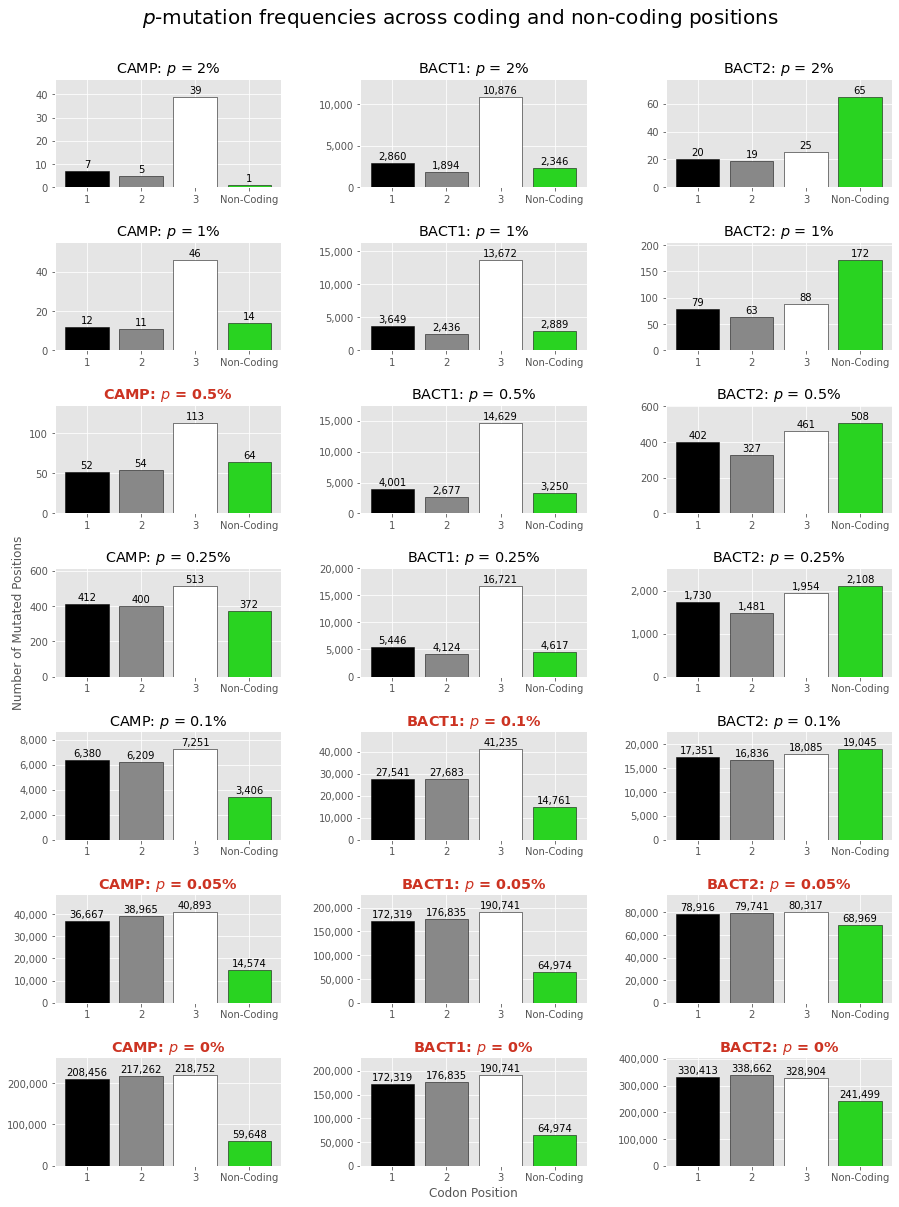

In [9]:
histogram_matrix_maker(percentages, figfilename="unnormalized-cp-hists.png")

### With normalization, and making y-axes comparable for each row

CAMP: $p$ = 2% [1.7609486985331296e-05, 1.2578204989522355e-05, 9.810999891827437e-05, 9.920044441799099e-06]
BACT1: $p$ = 2% [0.004405333842667968, 0.0029173784258787177, 0.016752591214285604, 0.011301775718043338]
BACT2: $p$ = 2% [2.605482978379702e-05, 2.475208829460717e-05, 3.2568537229746275e-05, 0.00012651033881415046]
CAMP: $p$ = 1% [3.0187691974853652e-05, 2.7672050976949182e-05, 0.00011571948590360566, 0.0001388806221851874]
BACT1: $p$ = 1% [0.005620651465697698, 0.00375223539885985, 0.02105934415977499, 0.013917659867616028]
BACT2: $p$ = 1% [0.00010291657764599824, 8.207271381896062e-05, 0.0001146412510487069, 0.00033476581963129046]
CAMP: $p$ = 0.5% [0.0001308133318910325, 0.00013584461388684144, 0.0002842674327632052, 0.0006348828442751423]
BACT1: $p$ = 0.5% [0.0061628464001799105, 0.004123454089797955, 0.022533436637898502, 0.01565676516779235]
BACT2: $p$ = 0.5% [0.0005237020786543202, 0.00042599646696508134, 0.0006005638265165214, 0.0009887269556552068]
CAMP: $p$ = 0.25% 

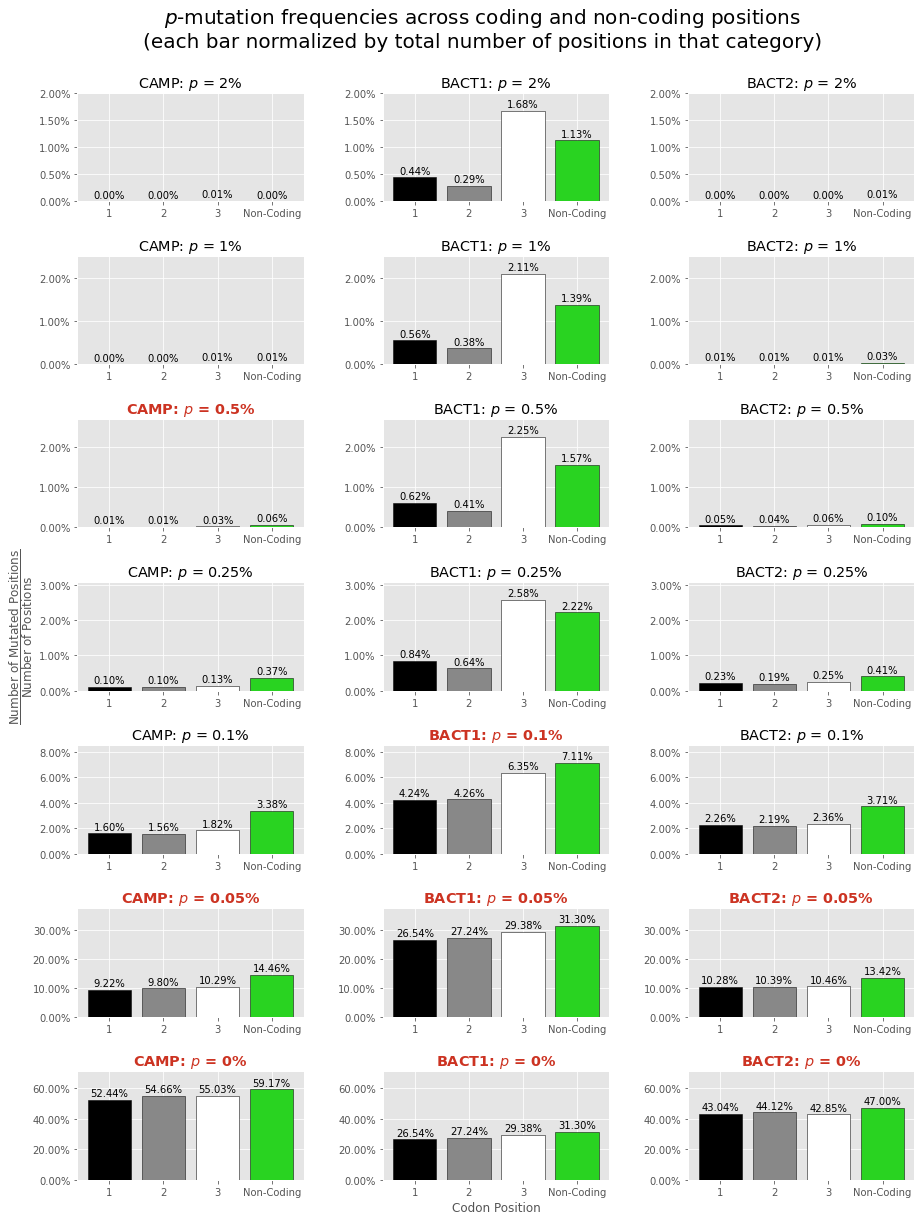

In [10]:
histogram_matrix_maker(percentages, normalize=True, make_yaxes_comparable=True,
                       figfilename="normalized-cp-hists.png")

## Visualize CP 1/2/3 plots of LoFreq variant calls

In [1]:
from pysam import VariantFile

In [37]:
lofreq_calls = VariantFile("../seqs/lofreq.vcf")
# We store the (1-indexed) positions that have variants as sets for each sequence, not lists. This is because
# lookup is a lot faster in sets (avg O(1)) than in lists (avg O(n)), and we repeatedly do lookup in
# histogram_maker(). This could maybe be made MORE efficient by storing the positions in sorted order (I think
# VCF guarantees the positions are already sorted) and then using binary search to check if a position has a
# variant associated with it, but not sure that's necessary at this point at least.
seq2lofreq_calls = {s: set() for s in SEQS}

for c in lofreq_calls.fetch():
    seq2lofreq_calls[c.contig].add(c.pos)

for seq in SEQS:
    print(f"{seq2name[seq]} had {len(seq2lofreq_calls[seq]):,} variants called by LoFreq.")

CAMP had 57 variants called by LoFreq.
BACT1 had 16,131 variants called by LoFreq.
BACT2 had 84 variants called by LoFreq.


CAMP [9, 6, 42, 0]
BACT1 [2518, 1605, 10398, 1615]
BACT2 [12, 10, 13, 49]


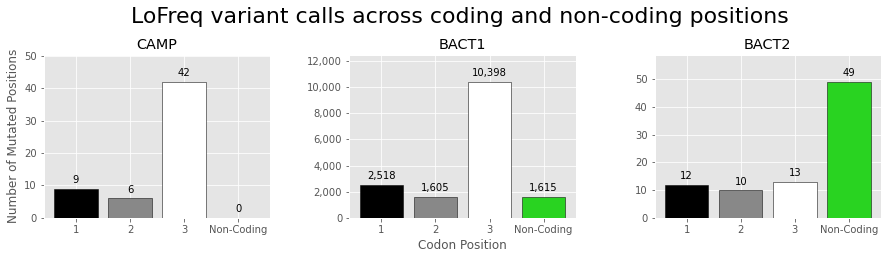

In [46]:
fig, axes = pyplot.subplots(1, 3, gridspec_kw={"wspace": 0.35})
histogram_maker(
    None,
    "",
    axes=axes,
    already_done_calls=seq2lofreq_calls
)

fig.suptitle("LoFreq variant calls across coding and non-coding positions", y=1.1, x=0.51, fontsize=22)
fig.set_size_inches(15, 3)
fig.savefig("figs/lofreq-cp-hists.png", bbox_inches="tight")